In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
# from myDataset import myDataset
# from datasets import TripletMNIST
# from add_softmax_layer import onlineUpdateNet
import pickle
import numpy as np
from PIL import Image
import collections
from torchvision import transforms

In [11]:
dataset = myDataset(r'D:\文档\Deepcamp\Dataset\deecamp_data\deecamp_24')

NameError: name 'myDataset' is not defined

In [3]:
img, label = dataset[0]

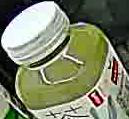

In [4]:
img

In [5]:
print(type(dataset.))

SyntaxError: invalid syntax (<ipython-input-5-c6bc87f4a17f>, line 1)

In [6]:
print(dataset.class_to_idx)

{'0725b0fa-5049-11e9-a657-0242cb7ccd7c': 0, '0af8df9c-716c-11e9-81f4-0242cb7ccd7c': 1, '0c14b476-d740-11e8-b552-0242cb7ccd7c': 2, '1641aac8-e0be-11e8-8688-0242cb7ccd7c': 3, '1f7d796e-5049-11e9-8bbf-0242cb7ccd7c': 4, '22798338-d5c7-11e8-bfcf-0242cb7ccd7c': 5, '338ca592-9ae4-11e8-a2c0-02422fc40004': 6, '4d6c3248-d6bd-11e8-8b47-0242cb7ccd7c': 7, '4ea3cca6-9ae5-11e8-8754-02422fc40004': 8, '4f46d0ac-bb35-11e8-9f16-0242cb74f9f9': 9, '6c940800-6b1f-11e9-95a7-0242cb7ccd7c': 10, '7fb76eec-83e6-11e8-881b-34363bd1db02': 11, '7fb775d8-83e6-11e8-95a8-34363bd1db02': 12, '7fb777ca-83e6-11e8-814b-34363bd1db02': 13, '7fb77db0-83e6-11e8-a2d7-34363bd1db02': 14, '8339dfe6-9ae3-11e8-a39f-02422fc40004': 15, 'a42c44de-d73a-11e8-b9a5-0242cb7ccd7c': 16, 'a81fa274-bb34-11e8-a75b-0242cb74f9f9': 17, 'c473ed6e-80e7-11e8-be39-34363bd1db02': 18, 'c475d67e-80e7-11e8-9d42-34363bd1db02': 19, 'c475e312-80e7-11e8-aada-34363bd1db02': 20, 'd00ba454-25fa-11e9-8f99-0242cb7ccd7c': 21, 'd1b9fae2-5048-11e9-8731-0242cb7ccd7c': 2

In [7]:
datasets = TripletMNIST(dataset)

In [8]:
datasets[0]

<class 'PIL.Image.Image'>


((<PIL.Image.Image image mode=RGB size=129x119 at 0x2BF622085F8>,
  <PIL.Image.Image image mode=RGB size=124x119 at 0x2BF5CD00A90>,
  <PIL.Image.Image image mode=RGB size=96x92 at 0x2BF622088D0>),
 [])

In [16]:
datasets.train_labels[11]

tensor(0.)

In [10]:
datasets.train_labels

tensor([ 0., 15.,  4.,  ..., 19.,  0.,  7.])

In [8]:
import os
import numpy as np
import shutil
from PIL import Image, ImageEnhance, ImageOps, ImageFile
import random


# 随机选择图片并进行resize

class DataAugmentation:
    """
    包含数据增强的八种方式
    """

    def __init__(self):
        pass

    @staticmethod
    def openImage(image):
        return Image.open(image, mode="r")

    @staticmethod
    def randomRotation(image, mode=Image.BICUBIC):
        """
         对图像进行随机任意角度(0~360度)旋转
        :param mode 邻近插值,双线性插值,双三次B样条插值(default)
        :param image PIL的图像image
        :return: 旋转转之后的图像
        """
        random_angle = np.random.randint(1, 360)
        return image.rotate(random_angle, mode)

    @staticmethod
    def randomColor(image):
        """
        对图像进行颜色抖动
        :param image: PIL的图像image
        :return: 有颜色色差的图像image
        """
        random_factor = np.random.randint(8, 12) / 10.  # 随机因子
        color_image = ImageEnhance.Color(image).enhance(random_factor)  # 调整图像的饱和度
        random_factor = np.random.randint(8, 12) / 10.  # 随机因子
        brightness_image = ImageEnhance.Brightness(color_image).enhance(random_factor)  # 调整图像的亮度
        random_factor = np.random.randint(8, 12) / 10.  # 随机因1子
        contrast_image = ImageEnhance.Contrast(brightness_image).enhance(random_factor)  # 调整图像对比度
        random_factor = np.random.randint(8, 12) / 10.  # 随机因子
        return ImageEnhance.Sharpness(contrast_image).enhance(random_factor)  # 调整图像锐度

    @staticmethod
    def randomGaussian(image, mean=0.2, sigma=0.3):
        """
         对图像进行高斯噪声处理
        :param image:
        :return:
        """

        def gaussianNoisy(im, mean=0.2, sigma=0.3):
            """
            对图像做高斯噪音处理
            :param im: 单通道图像
            :param mean: 偏移量
            :param sigma: 标准差
            :return:
            """
            for _i in range(len(im)):
                im[_i] += random.gauss(mean, sigma)
            return im

        # 将图像转化成数组
        img = np.asarray(image)
        img.flags.writeable = True  # 将数组改为读写模式
        width, height = img.shape[:2]
        img_r = gaussianNoisy(img[:, :, 0].flatten(), mean, sigma)
        img_g = gaussianNoisy(img[:, :, 1].flatten(), mean, sigma)
        img_b = gaussianNoisy(img[:, :, 2].flatten(), mean, sigma)
        img[:, :, 0] = img_r.reshape([width, height])
        img[:, :, 1] = img_g.reshape([width, height])
        img[:, :, 2] = img_b.reshape([width, height])
        return Image.fromarray(np.uint8(img))

    @staticmethod
    def process_all(image):
        image = DataAugmentation.randomRotation(image)
        image = DataAugmentation.randomColor(image)
        # image = DataAugmentation.randomGaussian(image)
        return image

    @staticmethod
    def saveImage(image, path):
        image.save(path)


def process_image_channels(image):
    # process the 4 channels .png
    if image.mode == 'RGBA':
        r, g, b, a = image.split()
        image = Image.merge("RGB", (r, g, b))
    # process the channel image
    elif image.mode != 'RGB':
        image = image.convert("RGB")
    return image


def image_enforce(image_path, times=4):
    image = DataAugmentation.openImage(image_path)
    image = process_image_channels(image)
    image = Scale((150, 150))(image)
    enforce_imgs = [DataAugmentation.process_all(image) for _ in range(times)]
    return [image] + enforce_imgs

In [13]:
class onlineUpdateNet(nn.Module):
    def __init__(self, encode_dim, pretrain_model_path, feature_points, ind_to_name, device, finetune=True):
        '''
        :param encode_dim: the dimension of feature points, 128
        :param pretrain_model_path: the path of pretrained model
        :param feature_points: the path of pretrained feature points, one feature point for each class, n_class * 128
        :param ind_to_name: dictionary that map label(int) to real class name
        :param device: define which GPU to run
        :param finetune:
        '''
        super(onlineUpdateNet, self).__init__()
        self.encode_dim = encode_dim
        self.encode_layer = models.resnet50(pretrained=False)
        in_features = self.encode_layer.fc.in_features
        self.encode_layer.fc = nn.Linear(in_features, encode_dim)
        state_dict = torch.load(pretrain_model_path)
        state = {}
        for k, v in state_dict.items():
            state[k[13:]] = v
        self.encode_layer.load_state_dict(state)

        self.device = device
        class_info = open(ind_to_name, 'rb')
        self.ind_to_name = pickle.load(class_info)
        class_info.close()

        file = open(feature_points, 'rb')
        self.feature_points = pickle.load(file)
        file.close()

    def forward(self, x):
        self.encode_layer.to(self.device)
        x = self.encode_layer(x)
        return x

    def predict(self, x):
        x = self.transform(x)
        x = x.to(self.device)
        calc_representation = self.forward(x).data.cpu().numpy()
#         print(calc_representation)
        distances = np.sqrt(((self.feature_points - calc_representation) ** 2).sum(axis=1))
        prob = np.exp(-distances) / np.exp(-distances).sum()
#         print(prob)
        pred_label = np.argmax(prob, axis=0)
        pred_class_name = self.ind_to_name[pred_label]
        return pred_class_name
    
    def predict_top(self, x, top=3):
        x = self.transform(x)
        x = x.to(self.device)
        calc_representation = self.forward(x).data.cpu().numpy()
#         print(calc_representation)
        distances = np.sqrt(((self.feature_points - calc_representation) ** 2).sum(axis=1))
        prob = np.exp(-distances) / np.exp(-distances).sum()
#         print(prob.shape)
        pred_label_list = np.argsort(prob.reshape(1, -1))
        pred_class_name = []
        for i in range(top):
            pred_class_name.append(self.ind_to_name[pred_label_list[0][-1-i]])
#             pred_class_name[self.ind_to_name[pred_label_list[0][-1-i]]] = prob[pred_label_list[0][-1-i]]
        
        return pred_class_name

    def transform(self, x):
        x = Image.open(x)
#         print(x.size)
        x = Scale((150, 150))(x)
        x = np.array(x)
#         print(x.shape)
        x = transforms.ToTensor()(x)
        x= x.unsqueeze(0)
#         print(x.size())
        return x
    
    def retrain(self, pic_list, sku_name):
        batch = torch.ones(1, 3, 150, 150)
        for pic_path in pic_list:
            enforce_pic_list = image_enforce(pic_path)
            for enforce_pic in enforce_pic_list:
                enforce_pic = transforms.ToTensor()(enforce_pic)
                enforce_pic = enforce_pic.unsqueeze(0)
                batch = torch.cat((batch, enforce_pic), 0)
        batch = batch[1:]
        batch = batch.to(self.device)
        calc_new_class_repre = self.forward(batch).mean(dim=0)
        self.feature_points = np.vstack((self.feature_points, calc_new_class_repre.data.cpu().numpy().reshape(1, self.encode_dim)))
        num_class = len(self.ind_to_name)
        num_class += 1
        self.ind_to_name[num_class-1] = sku_name
        self.save(self.feature_points, './models/class_%d_feature_points.pkl'%num_class)
        self.save(self.ind_to_name, './models/idx_to_name_%d.pkl'%num_class)
        return calc_new_class_repre.data.cpu().numpy()
    
    def save(self, obj, save_path):
        file = open(save_path, 'wb')
        pickle.dump(obj, file)
        file.close()
        
    
        


class Scale(object):
    """Rescales the input PIL.Image to the given 'size'.
    If 'size' is a 2-element tuple or list in the order of (width, height), it will be the exactly size to scale.
    If 'size' is a number, it will indicate the size of the smaller edge.
    For example, if height > width, then image will be
    rescaled to (size * height / width, size)
    size: size of the exactly size or the smaller edge
    interpolation: Default: PIL.Image.BILINEAR
    """


    def __init__(self, size, interpolation=Image.BILINEAR):
        assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation


    def __call__(self, img):
        if isinstance(self.size, int):
            w, h = img.size
            if (w <= h and w == self.size) or (h <= w and h == self.size):
                return img
            if w < h:
                ow = self.size
                oh = int(self.size * h / w)
                return img.resize((ow, oh), self.interpolation)
            else:
                oh = self.size
                ow = int(self.size * w / h)
                return img.resize((ow, oh), self.interpolation)
        else:
            return img.resize(self.size, self.interpolation)

In [11]:
class TripletLossNet(nn.Module):
    def __init__(self, encode_dim, pretrain_model_path, feature_points, ind_to_name, device, finetune=True):
        '''
        :param encode_dim: the dimension of feature points, 128
        :param pretrain_model_path: the path of pretrained model
        :param feature_points: the path of pretrained feature points, one feature point for each class, n_class * 128
        :param ind_to_name: dictionary that map label(int) to real class name
        :param device: define which GPU to run
        :param finetune:
        '''
        super(TripletLossNet, self).__init__()
        self.encode_dim = encode_dim
        self.encode_layer = models.resnet50(pretrained=False)
        in_features = self.encode_layer.fc.in_features
        self.encode_layer.fc = nn.Linear(in_features, encode_dim)
        state_dict = torch.load(pretrain_model_path,map_location='cpu')
        state = {}
        for k, v in state_dict.items():
            state[k[13:]] = v
        self.encode_layer.load_state_dict(state)

        self.device = device
        class_info = open(ind_to_name, 'rb')
        self.ind_to_name = pickle.load(class_info)
        class_info.close()

        file = open(feature_points, 'rb')
        self.feature_points = pickle.load(file)
        file.close()

    def forward(self, x):
        self.encode_layer.to(self.device)
        x = self.encode_layer(x)
        return x

    def predict(self, x):
        x = self.transform(x)
        x = x.to(self.device)
        calc_representation = self.forward(x).data.cpu().numpy()
#         print(calc_representation)
        distances = np.sqrt(((self.feature_points - calc_representation) ** 2).sum(axis=1))
        prob = np.exp(-distances) / np.exp(-distances).sum()
#         print(prob)
        pred_label = np.argmax(prob, axis=0)
        pred_class_name = self.ind_to_name[pred_label]
        return pred_class_name
    
    def predict_top(self, x, top=3):
        x = self.transform(x)
        x = x.to(self.device)
        calc_representation = self.forward(x).data.cpu().numpy()
#         print(calc_representation)
        distances = np.sqrt(((self.feature_points - calc_representation) ** 2).sum(axis=1))
        prob = np.exp(-distances) / np.exp(-distances).sum()
#         print(prob.shape)
        pred_label_list = np.argsort(prob.reshape(1, -1))
        pred_class_name = []
        pred_class_prob = []
        for i in range(top):
            pred_class_name.append(self.ind_to_name[pred_label_list[0][-1-i]])
            pred_class_prob.append(prob[pred_label_list[0][-1-i]])
        result = {'name': pred_class_name, 'prob': pred_class_prob}
        return result
    
    def retrain(self, pic_list, sku_name):
        batch = torch.ones(1, 3, 150, 150)
        for pic_path in pic_list:
            enforce_pic_list = image_enforce(pic_path)
            for enforce_pic in enforce_pic_list:
                enforce_pic = transforms.ToTensor()(enforce_pic)
                enforce_pic = enforce_pic.unsqueeze(0)
                batch = torch.cat((batch, enforce_pic), 0)
        batch = batch[1:]
        batch = batch.to(self.device)
        calc_new_class_repre = self.forward(batch).mean(dim=0)
        self.feature_points = np.vstack((self.feature_points, calc_new_class_repre.data.cpu().numpy().reshape(1, self.encode_dim)))
        num_class = len(self.ind_to_name)
        num_class += 1
        self.ind_to_name[num_class-1] = sku_name
        self.save(self.feature_points, './models/newest_model/feature_points.pkl')
        self.save(self.ind_to_name, './models/newest_model/idx_to_name.pkl')
        self.save(self.feature_points, './models/back_up/class_%d_feature_points.pkl'%num_class)
        self.save(self.ind_to_name, './models/back_up/idx_to_name_%d.pkl'%num_class)
        return calc_new_class_repre.data.cpu().numpy()
    
    def save(self, obj, save_path):
        file = open(save_path, 'wb')
        pickle.dump(obj, file)
        file.close()

    def transform(self, x):
        x = Image.open(x)
        x = Scale((150, 150))(x)
        x = np.array(x)
        x = transforms.ToTensor()(x)
        x= x.unsqueeze(0)
        return x

In [5]:
from TripletLoss import TripletLossNet

device = torch.device("cpu")

model = TripletLossNet(128, './models/pretrain_model.pth', './models/newest_model/feature_points.pkl', './models/newest_model/idx_to_name.pkl', device)
model.eval()

TripletLossNet(
  (encode_layer): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
        

In [12]:
# device = torch.device("cuda: 1" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = TripletLossNet(128, './models/pretrain_model.pth', './models/newest_model/feature_points.pkl', './models/newest_model/idx_to_name.pkl', device)
model.eval()

TripletLossNet(
  (encode_layer): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
        

In [6]:
path = r'../../../../data/data_132/a2fa224c-fa16-11e8-bb36-0242cb7ccd7c/738b335efda7a4ba45751d4046d46640.jpg918_1026_642_757.jpg'
model.predict(path)

'蒙牛真果粒芦荟味250ml'

In [7]:
import os
pic_list = []
root_dir = r'../../../../data/data_24/1f7d796e-5049-11e9-8bbf-0242cb7ccd7c'
path = r'D:\文档\Deepcamp\Dataset\deecamp_data\deecamp_24\8339dfe6-9ae3-11e8-a39f-02422fc40004'
path_1 = r'D:\文档\Deepcamp\Dataset\deecamp_data\deecamp_24\1f7d796e-5049-11e9-8bbf-0242cb7ccd7c'
# root_dir = r'./new_class'
# root_dir = r'./mikl_powder'
for file_name in os.listdir(root_dir):
    if '.jpg' in file_name:
        pic_list.append(os.path.join(root_dir, file_name))
print(len(pic_list))

2000


In [8]:
GT = '农夫山泉 茶π（茶派）柚子绿茶新包装500ml'
pic_ind = np.random.choice(np.array([i for i in range(len(pic_list))]), 6, replace=False, p=None)
pic_list_train = [pic_list[i] for i in pic_ind]

model.retrain(pic_list_train, GT)

array([ 0.10614309,  0.46614492,  0.91371626,  1.1447525 , -0.5436032 ,
       -0.14036764, -0.89435905,  0.4605867 , -0.30682877,  0.12401185,
        0.813332  , -0.34396654,  0.3518339 ,  0.5133808 , -0.28482696,
       -0.24471597, -0.4068258 ,  0.0897834 ,  0.5640644 , -0.42636088,
        0.42560992, -0.5690376 , -0.3530638 , -0.22962737, -0.4673891 ,
       -0.7812269 ,  0.39066893,  0.3417831 , -0.20495701, -0.27791974,
       -0.28697756, -0.29860106,  0.06580777, -0.21638669,  0.10926223,
        0.959523  , -0.21442482, -0.27609056, -0.16405286,  0.3793561 ,
       -0.06642929,  0.35695606,  0.09047982,  0.67231846,  0.45394975,
        0.15794185,  0.05904349,  0.43506142, -0.30837843,  0.54071575,
        0.5844346 , -0.80491173, -0.78406024, -0.06148685,  0.2127944 ,
        0.5619258 ,  0.29409236, -0.07146308,  0.04000125, -0.15479085,
       -0.573704  , -0.7822594 ,  0.5889316 ,  0.0110728 ,  0.39620778,
        0.85132194, -0.38886786, -0.28595898, -0.65939605, -0.26

In [9]:
label = []
for pic in pic_list[:200]:
    name= model.predict(pic)
    label.append(name)
#     calc_reps = np.vstack((calc_reps, rep.reshape(1, 128)))


In [12]:
label

['农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶 500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶 500ml',
 '农夫山泉 茶π（茶派）柚子绿茶 500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柠檬红茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柠檬红茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柠檬红茶新包装500ml',
 '农夫山泉 茶π（茶派）柚子绿茶新包装500ml',
 '农夫山泉 茶π（茶派）柠檬红茶新包装500ml'

In [141]:
import matplotlib.pyplot as plt
from sklearn import manifold, datasets

In [143]:
tsne = manifold.TSNE(n_components=2,init='pca', random_state=501)
X_tsne = tsne.fit_transform(calc_reps)

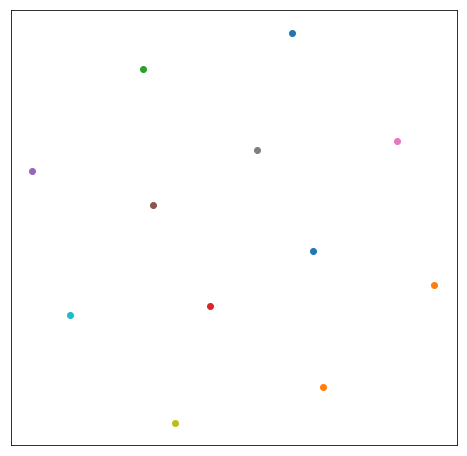

In [146]:
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(8, 8))
for i in range(X_norm.shape[0]):
    plt.scatter(X_norm[i, 0], X_norm[i, 1])
plt.xticks([])
plt.yticks([])
plt.show()

In [150]:
lux_rep = model.feature_points[-2]
milk_rep = model.feature_points[-1]

In [ ]:
def calc_distance()

In [35]:
from tqdm import tqdm
predict_res = []
count = 0
for i in tqdm(range(2000)):
    predict = model.predict_top(pic_list[i])
    if GT in predict:
        count += 1
    predict_res.append(predict)

100%|██████████| 2000/2000 [05:21<00:00,  8.09it/s]


In [37]:
count = 0
for i in predict_res:
    if i[0] == GT:
        count += 1

In [38]:
count

1267

In [33]:
predict_res[:10]

[['可口可乐 330ml', '可口可乐摩登罐330ml', '好丽友巧克力派2枚装68g'],
 ['可口可乐摩登罐330ml', '可口可乐 330ml', '好丽友巧克力派2枚装68g'],
 ['可口可乐摩登罐330ml', '可口可乐 330ml', '可口可乐零度可乐330ml_重复商品，不可上架'],
 ['可口可乐摩登罐330ml', '可口可乐 330ml', '旺仔牛奶245ml'],
 ['可口可乐 330ml', '可口可乐摩登罐330ml', '旺仔牛奶245ml'],
 ['可口可乐 330ml', '可口可乐摩登罐330ml', '加多宝红罐310ml'],
 ['可口可乐摩登罐330ml', '可口可乐600ml', '可口可乐 330ml'],
 ['可口可乐 330ml', '可口可乐摩登罐330ml', '旺仔牛奶245ml'],
 ['可口可乐摩登罐330ml', '可口可乐 330ml', '农夫山泉550ml'],
 ['可口可乐摩登罐330ml', '可口可乐 330ml', '乐虎250ml']]

In [47]:
acc = []
train_sample = 6
for i in range(10):
    device = torch.device("cuda: 3" if torch.cuda.is_available() else "cpu")
    model = onlineUpdateNet(132, 128, './models/pretrain_model.pth', './models/class_132_feature_points.pkl', './models/idx_to_name.pkl', device)
    model.eval()

#     import os
#     pic_list = []
#     # root_dir = r'D:\PycharmProjects\pytorch\Visualization\few_shot_learning\test'
#     root_dir = r'../../../../data/data_24/0c14b476-d740-11e8-b552-0242cb7ccd7c'
#     for file_name in os.listdir(root_dir):
#         pic_list.append(os.path.join(root_dir, file_name))
    
    pic_ind = np.random.choice(np.array([i for i in range(len(pic_list))]), train_sample, replace=False, p=None)
    print(pic_ind)
    pic_list_train = [pic_list[i] for i in pic_ind]
    model.retrain(pic_list_train, GT)
    
    predict_res = []
    count = 0
    for i in tqdm(range(len(pic_list))):
        predict = model.predict(pic_list[i])
        if predict == GT:
            count += 1
        predict_res.append(predict)
    print(count/2000)
    acc.append(count/2000)
    train_sample += 6

[1290  180  919 1643  322 1531]


100%|██████████| 2000/2000 [00:47<00:00, 41.23it/s]


0.825
[1282 1548  277  518 1116 1487  767 1246 1702 1685  888  490]


100%|██████████| 2000/2000 [00:41<00:00, 47.77it/s]


0.8385
[1925  965   26  566 1171  702 1964  894  261  404 1604 1359 1194  346
  268  903  991 1800]


100%|██████████| 2000/2000 [00:47<00:00, 42.54it/s]


0.827
[1808  450  513  166  184  926 1421 1216  983  933 1158 1338   35  149
 1744  897  719 1231  986  838 1030  797  297 1971]


100%|██████████| 2000/2000 [00:40<00:00, 49.06it/s]


0.8285
[1073 1538 1877  316 1581 1216  868 1428 1354  537 1110 1545 1447 1255
 1507 1082   12   17  989 1612 1988  258  422  641  776 1274 1754  634
 1933   65]


100%|██████████| 2000/2000 [00:46<00:00, 34.98it/s]


0.8055
[ 966  792 1664 1996  971 1822   31 1463  977  643 1439 1567 1117  994
 1396  610 1404  907  945 1849 1448  799 1012 1557  913  100 1493  540
 1805   76 1422  259 1170  535 1735  438]


100%|██████████| 2000/2000 [00:40<00:00, 49.66it/s]


0.8
[ 613 1506  178  856 1202   88  397 1080  314 1846    1  905  977  388
  896 1318 1528  549 1278 1870 1798 1854 1411  586 1659  678  702 1751
 1754  911  296  442 1593 1115  786 1675  131 1658 1834  385 1505 1832]


100%|██████████| 2000/2000 [00:47<00:00, 42.50it/s]


0.8145
[1845 1426  612 1002  772 1498  626  606  314  270  319  411 1543  529
  743  787   92  234 1539  509  597  193  422 1658 1067  843  851 1636
  938 1488  469 1070 1945 1276 1341 1830 1232  378  171  694  653  633
 1077 1872  840 1056  546 1615]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
predict_res = []
count = 0
for i in tqdm(range(len(pic_list))):
    predict = model.predict(pic_list[i])
    if predict == GT:
        count += 1
    predict_res.append(predict)
print(count/2000)

In [16]:
import pickle
import torch
import torchvision.models as models

In [20]:
state_dict = torch.load('./models/tripletLoss_class_132_agm_no_pretrain.pth')

In [21]:
encode_layer = models.resnet50(pretrained=False)
in_features = encode_layer.fc.in_features
encode_layer.fc = nn.Linear(in_features, 128)

In [22]:
encode_layer.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [23]:
for k, v in state_dict.items():
    print(k)

conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.bn3.running_mean
layer1.0.bn3.running_var
layer1.0.bn3.num_batches_tracked
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.0.downsample.1.running_mean
layer1.0.downsample.1.running_var
layer1.0.downsample.1.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tr